<a href="https://colab.research.google.com/github/THESHAMIK/Real-Life-Projects/blob/main/H2O/H2O_Tunning_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Series of **TUNNing used here** first with GBM, then tunning params of gbm + Early Stopping, then using GRID Search to get BEST params, then using KFOLD Cross Validation then using XGBoost, then using AUTOML which has highest AUC = 0.84. AutoML won.
So 7 steps followed 
https://www.kaggle.com/code/sudalairajkumar/getting-started-with-h2o/notebook
https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb:

In [ ]:
#!nvidia-smi
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.14.1" 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
!pip install h2o

     |████████████████████████████████| 177.0 MB 17 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.1-py2.py3-none-any.whl size=177068062 sha256=e7f7052e86a6c4bff296cb490b72a0b427849904603099792067eac0a8a7d6bf
  Stored in directory: /root/.cache/pip/wheels/a6/d9/ab/5442447c7e2ccf07f66aa8b79f3877ce5382f0b95e6c0c797b
Successfully built h2o


In [ ]:
import h2o
import time
import seaborn
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwcx50esx
  JVM stdout: /tmp/tmpwcx50esx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwcx50esx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_unknownUser_9woxgs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "diabetes.csv" with length 23873 bytes


In [ ]:
# Load data into H2O
diabetes_df = h2o.import_file("diabetes.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
diabetes_df.describe()

Rows:768
Cols:9




,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
type,int,int,int,int,int,real,real,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
mean,3.845052083333336,120.89453125,69.10546874999994,20.536458333333357,79.79947916666666,31.99257812500003,0.4718763020833334,33.240885416666615,0.3489583333333333
maxs,17.0,199.0,122.0,99.0,846.0,67.1,2.42,81.0,1.0
sigma,3.36957806269887,31.972618195136224,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.47695137724279896
zeros,111,5,35,227,374,11,0,0,500
missing,0,0,0,0,0,0,0,0,0
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0


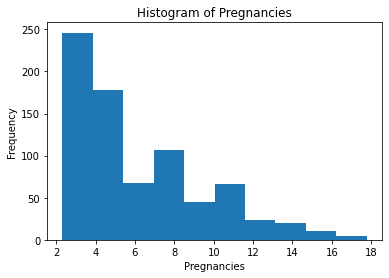

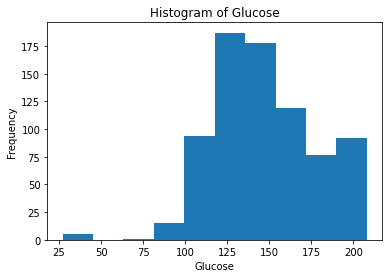

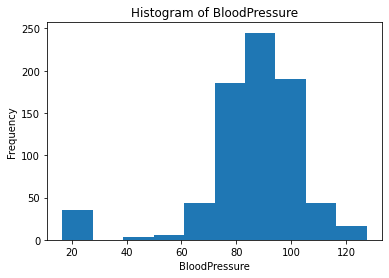

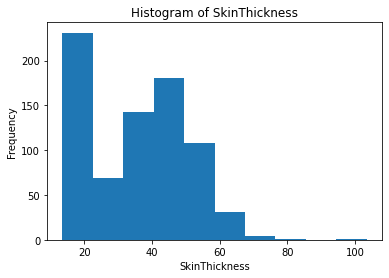

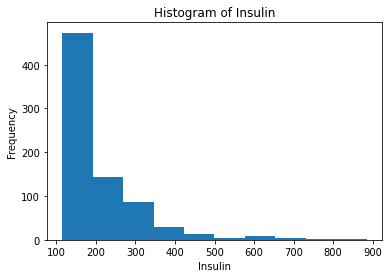

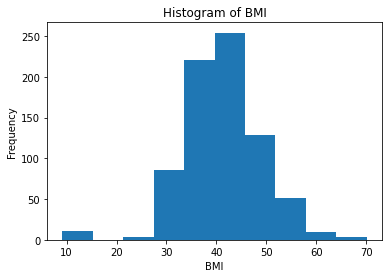

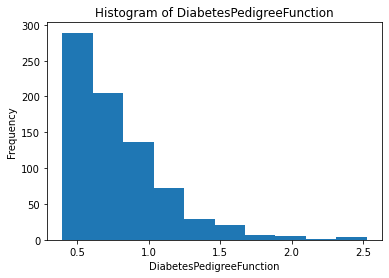

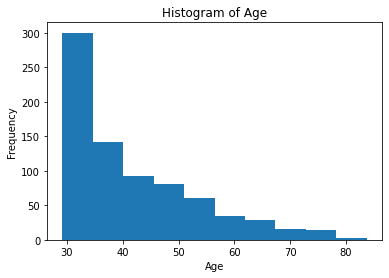

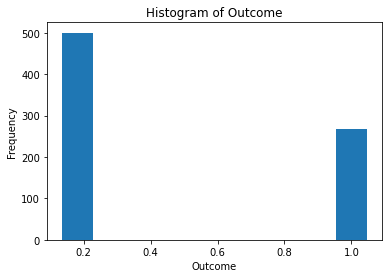

In [ ]:
for col in diabetes_df.columns:
    diabetes_df[col].hist()

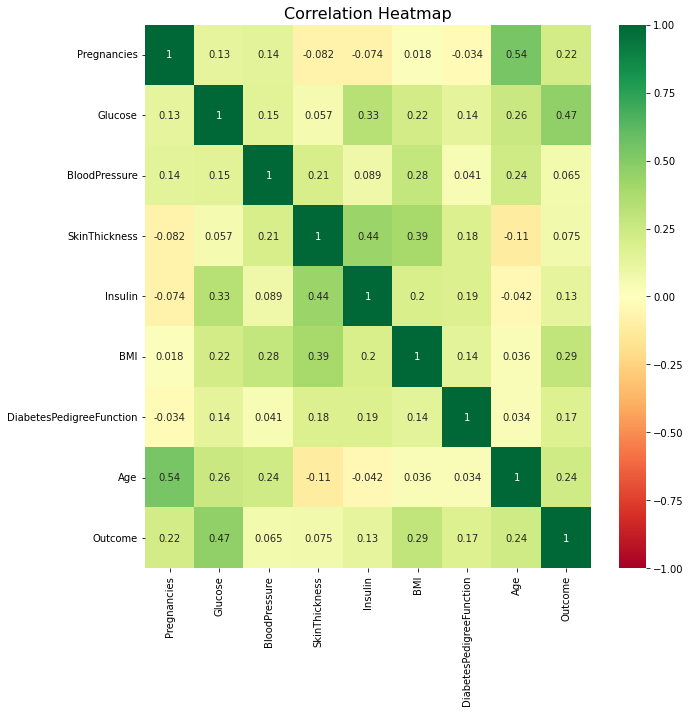

In [ ]:
plt.figure(figsize=(10,10))
corr = diabetes_df.cor().as_data_frame()
corr.index = diabetes_df.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [ ]:
train, valid, test = diabetes_df.split_frame(ratios=[0.6,0.2], seed=1234)
response = "Outcome"
train[response] = train[response].asfactor()
valid[response] = valid[response].asfactor()
test[response] = test[response].asfactor()
print("Number of rows in train, valid and test set : ", train.shape[0], valid.shape[0], test.shape[0])

Number of rows in train, valid and test set :  465 148 155


In [ ]:
predictors = diabetes_df.columns[:-1]
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors, y=response, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1650023430439_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,11548.0,5.0,5.0,5.0,6.0,23.0,13.68




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05394537414652564
RMSE: 0.2322614349101582
LogLoss: 0.21164045617145613
Mean Per-Class Error: 0.05721884192287545
AUC: 0.9899262602248459
AUCPR: 0.9845164166436653
Gini: 0.9798525204496917

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46220528851885034: 


,,0,1,Error,Rate
0,0,290.0,9.0,0.0301,(9.0/299.0)
1,1,14.0,152.0,0.0843,(14.0/166.0)
2,Total,304.0,161.0,0.0495,(23.0/465.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.462205,0.929664,150.0
1,max f2,0.323826,0.944836,176.0
2,max f0point5,0.548022,0.967302,132.0
3,max accuracy,0.506976,0.950538,142.0
4,max precision,0.983850,1.000000,0.0
5,max recall,0.173383,1.000000,227.0
6,max specificity,0.983850,1.000000,0.0
7,max absolute_mcc,0.506976,0.892066,142.0
8,max min_per_class_accuracy,0.372134,0.939799,163.0
9,max mean_per_class_accuracy,0.370458,0.945803,164.0



Gains/Lift Table: Avg response rate: 35.70 %, avg score: 35.71 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010753,0.964760,2.801205,2.801205,1.000000,0.970134,1.000000,0.970134,0.030120,0.030120,180.120482,180.120482,0.030120
1,2,0.021505,0.959842,2.801205,2.801205,1.000000,0.963441,1.000000,0.966788,0.030120,0.060241,180.120482,180.120482,0.060241
2,3,0.030108,0.948198,2.801205,2.801205,1.000000,0.952824,1.000000,0.962798,0.024096,0.084337,180.120482,180.120482,0.084337
3,4,0.040860,0.944016,2.801205,2.801205,1.000000,0.946246,1.000000,0.958442,0.030120,0.114458,180.120482,180.120482,0.114458
4,5,0.051613,0.940243,2.801205,2.801205,1.000000,0.942268,1.000000,0.955073,0.030120,0.144578,180.120482,180.120482,0.144578
5,6,0.101075,0.910936,2.801205,2.801205,1.000000,0.924669,1.000000,0.940194,0.138554,0.283133,180.120482,180.120482,0.283133
6,7,0.150538,0.868553,2.801205,2.801205,1.000000,0.889815,1.000000,0.923641,0.138554,0.421687,180.120482,180.120482,0.421687
7,8,0.200000,0.797054,2.801205,2.801205,1.000000,0.834641,1.000000,0.901630,0.138554,0.560241,180.120482,180.120482,0.560241
8,9,0.301075,0.556327,2.801205,2.801205,1.000000,0.680179,1.000000,0.827286,0.283133,0.843373,180.120482,180.120482,0.843373
9,10,0.400000,0.326087,1.157019,2.394578,0.413043,0.441848,0.854839,0.731963,0.114458,0.957831,15.701938,139.457831,0.867530




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-04-15 11:54:29,0.126 sec,0.0,0.479112,0.651666,0.500000,0.356989,1.000000,0.643011
1,,2022-04-15 11:54:30,0.621 sec,1.0,0.456602,0.606210,0.899111,0.841991,2.801205,0.178495
2,,2022-04-15 11:54:30,0.688 sec,2.0,0.437174,0.568855,0.918050,0.868180,2.801205,0.154839
3,,2022-04-15 11:54:30,0.747 sec,3.0,0.420575,0.537898,0.919994,0.870297,2.801205,0.156989
4,,2022-04-15 11:54:30,0.788 sec,4.0,0.405987,0.511169,0.925938,0.881996,2.801205,0.148387
5,,2022-04-15 11:54:30,0.834 sec,5.0,0.392586,0.486722,0.934239,0.894388,2.801205,0.141935
6,,2022-04-15 11:54:30,0.874 sec,6.0,0.380476,0.464792,0.937936,0.899843,2.801205,0.141935
7,,2022-04-15 11:54:30,0.918 sec,7.0,0.370456,0.446541,0.939205,0.901852,2.801205,0.139785
8,,2022-04-15 11:54:30,0.964 sec,8.0,0.362031,0.431383,0.942207,0.906607,2.801205,0.133333
9,,2022-04-15 11:54:30,1.015 sec,9.0,0.355361,0.418882,0.941834,0.907237,2.801205,0.133333



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Glucose,160.889725,1.000000,0.386115
1,BMI,107.157028,0.666028,0.257163
2,DiabetesPedigreeFunction,49.382526,0.306934,0.118512
3,Age,28.789474,0.178939,0.069091
4,BloodPressure,24.516136,0.152379,0.058836
5,Pregnancies,22.055462,0.137084,0.052930
6,Insulin,12.949581,0.080487,0.031077
7,SkinThickness,10.949017,0.068053,0.026276


In [ ]:
print(gbm)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1650023430439_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,11548.0,5.0,5.0,5.0,6.0,23.0,13.68




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05394537414652564
RMSE: 0.2322614349101582
LogLoss: 0.21164045617145613
Mean Per-Class Error: 0.05721884192287545
AUC: 0.9899262602248459
AUCPR: 0.9845164166436653
Gini: 0.9798525204496917

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46220528851885034: 


,,0,1,Error,Rate
0,0,290.0,9.0,0.0301,(9.0/299.0)
1,1,14.0,152.0,0.0843,(14.0/166.0)
2,Total,304.0,161.0,0.0495,(23.0/465.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.462205,0.929664,150.0
1,max f2,0.323826,0.944836,176.0
2,max f0point5,0.548022,0.967302,132.0
3,max accuracy,0.506976,0.950538,142.0
4,max precision,0.983850,1.000000,0.0
5,max recall,0.173383,1.000000,227.0
6,max specificity,0.983850,1.000000,0.0
7,max absolute_mcc,0.506976,0.892066,142.0
8,max min_per_class_accuracy,0.372134,0.939799,163.0
9,max mean_per_class_accuracy,0.370458,0.945803,164.0



Gains/Lift Table: Avg response rate: 35.70 %, avg score: 35.71 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010753,0.964760,2.801205,2.801205,1.000000,0.970134,1.000000,0.970134,0.030120,0.030120,180.120482,180.120482,0.030120
1,2,0.021505,0.959842,2.801205,2.801205,1.000000,0.963441,1.000000,0.966788,0.030120,0.060241,180.120482,180.120482,0.060241
2,3,0.030108,0.948198,2.801205,2.801205,1.000000,0.952824,1.000000,0.962798,0.024096,0.084337,180.120482,180.120482,0.084337
3,4,0.040860,0.944016,2.801205,2.801205,1.000000,0.946246,1.000000,0.958442,0.030120,0.114458,180.120482,180.120482,0.114458
4,5,0.051613,0.940243,2.801205,2.801205,1.000000,0.942268,1.000000,0.955073,0.030120,0.144578,180.120482,180.120482,0.144578
5,6,0.101075,0.910936,2.801205,2.801205,1.000000,0.924669,1.000000,0.940194,0.138554,0.283133,180.120482,180.120482,0.283133
6,7,0.150538,0.868553,2.801205,2.801205,1.000000,0.889815,1.000000,0.923641,0.138554,0.421687,180.120482,180.120482,0.421687
7,8,0.200000,0.797054,2.801205,2.801205,1.000000,0.834641,1.000000,0.901630,0.138554,0.560241,180.120482,180.120482,0.560241
8,9,0.301075,0.556327,2.801205,2.801205,1.000000,0.680179,1.000000,0.827286,0.283133,0.843373,180.120482,180.120482,0.843373
9,10,0.400000,0.326087,1.157019,2.394578,0.413043,0.441848,0.854839,0.731963,0.114458,0.957831,15.701938,139.457831,0.867530




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-04-15 11:54:29,0.126 sec,0.0,0.479112,0.651666,0.500000,0.356989,1.000000,0.643011
1,,2022-04-15 11:54:30,0.621 sec,1.0,0.456602,0.606210,0.899111,0.841991,2.801205,0.178495
2,,2022-04-15 11:54:30,0.688 sec,2.0,0.437174,0.568855,0.918050,0.868180,2.801205,0.154839
3,,2022-04-15 11:54:30,0.747 sec,3.0,0.420575,0.537898,0.919994,0.870297,2.801205,0.156989
4,,2022-04-15 11:54:30,0.788 sec,4.0,0.405987,0.511169,0.925938,0.881996,2.801205,0.148387
5,,2022-04-15 11:54:30,0.834 sec,5.0,0.392586,0.486722,0.934239,0.894388,2.801205,0.141935
6,,2022-04-15 11:54:30,0.874 sec,6.0,0.380476,0.464792,0.937936,0.899843,2.801205,0.141935
7,,2022-04-15 11:54:30,0.918 sec,7.0,0.370456,0.446541,0.939205,0.901852,2.801205,0.139785
8,,2022-04-15 11:54:30,0.964 sec,8.0,0.362031,0.431383,0.942207,0.906607,2.801205,0.133333
9,,2022-04-15 11:54:30,1.015 sec,9.0,0.355361,0.418882,0.941834,0.907237,2.801205,0.133333



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Glucose,160.889725,1.000000,0.386115
1,BMI,107.157028,0.666028,0.257163
2,DiabetesPedigreeFunction,49.382526,0.306934,0.118512
3,Age,28.789474,0.178939,0.069091
4,BloodPressure,24.516136,0.152379,0.058836
5,Pregnancies,22.055462,0.137084,0.052930
6,Insulin,12.949581,0.080487,0.031077
7,SkinThickness,10.949017,0.068053,0.026276


In [ ]:
perf = gbm.model_performance(valid)
print(perf)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.18115330538099383
RMSE: 0.4256210819273334
LogLoss: 0.5366686568411096
Mean Per-Class Error: 0.25621588841722254
AUC: 0.804932282191227
AUCPR: 0.6470306042290592
Gini: 0.6098645643824541

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1458393490707833: 


,,0,1,Error,Rate
0,0,53.0,44.0,0.4536,(44.0/97.0)
1,1,3.0,48.0,0.0588,(3.0/51.0)
2,Total,56.0,92.0,0.3176,(47.0/148.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.145839,0.671329,91.0
1,max f2,0.112531,0.819936,106.0
2,max f0point5,0.668426,0.642458,31.0
3,max accuracy,0.668426,0.750000,31.0
4,max precision,0.980739,1.000000,0.0
5,max recall,0.112531,1.000000,106.0
6,max specificity,0.980739,1.000000,0.0
7,max absolute_mcc,0.145839,0.477769,91.0
8,max min_per_class_accuracy,0.328581,0.686275,64.0
9,max mean_per_class_accuracy,0.145839,0.743784,91.0



Gains/Lift Table: Avg response rate: 34.46 %, avg score: 36.45 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013514,0.973098,1.450980,1.450980,0.500000,0.977228,0.500000,0.977228,0.019608,0.019608,45.098039,45.098039,0.009299
1,2,0.020270,0.966872,2.901961,1.934641,1.000000,0.972400,0.666667,0.975618,0.019608,0.039216,190.196078,93.464052,0.028906
2,3,0.033784,0.952356,2.901961,2.321569,1.000000,0.963776,0.800000,0.970881,0.039216,0.078431,190.196078,132.156863,0.068122
3,4,0.040541,0.927994,2.901961,2.418301,1.000000,0.939870,0.833333,0.965713,0.019608,0.098039,190.196078,141.830065,0.087730
4,5,0.054054,0.923162,1.450980,2.176471,0.500000,0.925415,0.750000,0.955638,0.019608,0.117647,45.098039,117.647059,0.097029
5,6,0.101351,0.892244,2.072829,2.128105,0.714286,0.906349,0.733333,0.932637,0.098039,0.215686,107.282913,112.810458,0.174449
6,7,0.155405,0.836001,2.176471,2.144928,0.750000,0.861825,0.739130,0.908006,0.117647,0.333333,117.647059,114.492754,0.271478
7,8,0.202703,0.722515,1.658263,2.031373,0.571429,0.773092,0.700000,0.876527,0.078431,0.411765,65.826331,103.137255,0.318981
8,9,0.304054,0.517149,1.547712,1.870153,0.533333,0.605657,0.644444,0.786237,0.156863,0.568627,54.771242,87.015251,0.403679
9,10,0.398649,0.409838,1.036415,1.672316,0.357143,0.461534,0.576271,0.709188,0.098039,0.666667,3.641457,67.231638,0.408935


So using our baseline model, we are getting about **0.8 auc in valid set and 0.98** auc in train set. Similarly, log loss is 0.53 in valid set and 0.21 in train set.

Now we can** use the validation set to tune our parameters.** We can use the early stopping to find the number of iterations to train similar to other GBM implementations. We can set some random values for the parameters to start with. 

In [ ]:
gbm_tune = H2OGradientBoostingEstimator(
    ntrees = 3000,
    learn_rate = 0.01,
    stopping_rounds = 20,
    stopping_metric = "AUC",
    col_sample_rate = 0.7,
    sample_rate = 0.7,
    seed = 1234
)      
gbm_tune.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

gbm Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1650023430439_54


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,13034.0,5.0,5.0,5.0,13.0,22.0,17.891304




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.16518968941442272
RMSE: 0.40643534469140685
LogLoss: 0.5115661709706083
Mean Per-Class Error: 0.1314522303259862
AUC: 0.9354776967401377
AUCPR: 0.8897929742456694
Gini: 0.8709553934802754

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33018826601891127: 


,,0,1,Error,Rate
0,0,233.0,66.0,0.2207,(66.0/299.0)
1,1,7.0,159.0,0.0422,(7.0/166.0)
2,Total,240.0,225.0,0.157,(73.0/465.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.330188,0.813299,207.0
1,max f2,0.330188,0.894263,207.0
2,max f0point5,0.420919,0.826211,126.0
3,max accuracy,0.401770,0.855914,137.0
4,max precision,0.581368,1.000000,0.0
5,max recall,0.275007,1.000000,287.0
6,max specificity,0.581368,1.000000,0.0
7,max absolute_mcc,0.330188,0.706670,207.0
8,max min_per_class_accuracy,0.366930,0.846154,172.0
9,max mean_per_class_accuracy,0.330188,0.868548,207.0



Gains/Lift Table: Avg response rate: 35.70 %, avg score: 35.61 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010753,0.568970,2.801205,2.801205,1.000000,0.572539,1.000000,0.572539,0.030120,0.030120,180.120482,180.120482,0.030120
1,2,0.021505,0.565482,2.801205,2.801205,1.000000,0.567511,1.000000,0.570025,0.030120,0.060241,180.120482,180.120482,0.060241
2,3,0.030108,0.560381,2.801205,2.801205,1.000000,0.563216,1.000000,0.568080,0.024096,0.084337,180.120482,180.120482,0.084337
3,4,0.040860,0.555895,2.801205,2.801205,1.000000,0.557806,1.000000,0.565376,0.030120,0.114458,180.120482,180.120482,0.114458
4,5,0.051613,0.550417,2.801205,2.801205,1.000000,0.553400,1.000000,0.562881,0.030120,0.144578,180.120482,180.120482,0.144578
5,6,0.101075,0.523372,2.801205,2.801205,1.000000,0.536264,1.000000,0.549856,0.138554,0.283133,180.120482,180.120482,0.283133
6,7,0.150538,0.502357,2.192247,2.601119,0.782609,0.512631,0.928571,0.537625,0.108434,0.391566,119.224725,160.111876,0.374844
7,8,0.200000,0.472793,2.557622,2.590361,0.913043,0.488762,0.924731,0.525540,0.126506,0.518072,155.762179,159.036145,0.494661
8,9,0.301075,0.405201,1.966803,2.381024,0.702128,0.440389,0.850000,0.496954,0.198795,0.716867,96.680338,138.102410,0.646633
9,10,0.400000,0.366927,1.339707,2.123494,0.478261,0.386062,0.758065,0.469529,0.132530,0.849398,33.970665,112.349398,0.698896




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.18921804289735072
RMSE: 0.43499200325678483
LogLoss: 0.5634654900419724
Mean Per-Class Error: 0.26399838285829796
AUC: 0.8019001414998989
AUCPR: 0.6808591759676361
Gini: 0.6038002829997977

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3235163299950883: 


,,0,1,Error,Rate
0,0,61.0,36.0,0.3711,(36.0/97.0)
1,1,8.0,43.0,0.1569,(8.0/51.0)
2,Total,69.0,79.0,0.2973,(44.0/148.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.323516,0.661538,78.0
1,max f2,0.273490,0.796178,109.0
2,max f0point5,0.472237,0.645161,25.0
3,max accuracy,0.472237,0.750000,25.0
4,max precision,0.565010,1.000000,0.0
5,max recall,0.260912,1.000000,119.0
6,max specificity,0.565010,1.000000,0.0
7,max absolute_mcc,0.323516,0.449653,78.0
8,max min_per_class_accuracy,0.357593,0.705882,60.0
9,max mean_per_class_accuracy,0.323516,0.736002,78.0



Gains/Lift Table: Avg response rate: 34.46 %, avg score: 35.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013514,0.559395,2.901961,2.901961,1.000000,0.562857,1.000000,0.562857,0.039216,0.039216,190.196078,190.196078,0.039216
1,2,0.020270,0.557053,2.901961,2.901961,1.000000,0.557918,1.000000,0.561211,0.019608,0.058824,190.196078,190.196078,0.058824
2,3,0.033784,0.554301,1.450980,2.321569,0.500000,0.555822,0.800000,0.559055,0.019608,0.078431,45.098039,132.156863,0.068122
3,4,0.040541,0.550623,2.901961,2.418301,1.000000,0.553804,0.833333,0.558180,0.019608,0.098039,190.196078,141.830065,0.087730
4,5,0.054054,0.545687,2.901961,2.539216,1.000000,0.548461,0.875000,0.555750,0.039216,0.137255,190.196078,153.921569,0.126946
5,6,0.101351,0.514323,2.072829,2.321569,0.714286,0.530000,0.800000,0.543734,0.098039,0.235294,107.282913,132.156863,0.204366
6,7,0.155405,0.483317,1.813725,2.144928,0.625000,0.495476,0.739130,0.526949,0.098039,0.333333,81.372549,114.492754,0.271478
7,8,0.202703,0.449802,1.658263,2.031373,0.571429,0.468498,0.700000,0.513310,0.078431,0.411765,65.826331,103.137255,0.318981
8,9,0.304054,0.403333,1.547712,1.870153,0.533333,0.420919,0.644444,0.482513,0.156863,0.568627,54.771242,87.015251,0.403679
9,10,0.398649,0.361932,1.036415,1.672316,0.357143,0.382910,0.576271,0.458879,0.098039,0.666667,3.641457,67.231638,0.408935




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-04-15 11:58:53,0.017 sec,0.0,0.479112,0.651666,0.500000,0.356989,1.000000,0.643011,0.475398,0.644373,0.500000,0.344595,1.000000,0.655405
1,,2022-04-15 11:58:53,0.090 sec,1.0,0.476998,0.647270,0.865808,0.783919,2.641136,0.223656,0.473919,0.641318,0.787447,0.672068,2.901961,0.364865
2,,2022-04-15 11:58:53,0.115 sec,2.0,0.474953,0.643043,0.900784,0.839639,2.801205,0.176344,0.472391,0.638174,0.809480,0.694902,2.901961,0.297297
3,,2022-04-15 11:58:53,0.162 sec,3.0,0.472849,0.638719,0.913054,0.860657,2.801205,0.167742,0.471288,0.635911,0.802203,0.660827,2.901961,0.304054
4,,2022-04-15 11:58:53,0.193 sec,4.0,0.470795,0.634518,0.915653,0.868230,2.801205,0.159140,0.469959,0.633193,0.803315,0.680394,2.901961,0.331081
5,,2022-04-15 11:58:53,0.215 sec,5.0,0.469410,0.631697,0.922362,0.869177,2.801205,0.152688,0.469225,0.631698,0.798464,0.678101,2.901961,0.304054
6,,2022-04-15 11:58:54,0.238 sec,6.0,0.467354,0.627533,0.926401,0.876527,2.801205,0.163441,0.468107,0.629426,0.792602,0.673781,2.901961,0.283784
7,,2022-04-15 11:58:54,0.259 sec,7.0,0.465395,0.623587,0.925736,0.879003,2.801205,0.169892,0.466752,0.626679,0.801294,0.677951,2.901961,0.277027
8,,2022-04-15 11:58:54,0.291 sec,8.0,0.463343,0.619472,0.926492,0.877016,2.801205,0.165591,0.465326,0.623797,0.815646,0.700983,2.901961,0.277027
9,,2022-04-15 11:58:54,0.325 sec,9.0,0.461292,0.615385,0.924356,0.875085,2.801205,0.165591,0.463992,0.621111,0.814332,0.707035,2.901961,0.270270



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Glucose,642.617126,1.000000,0.474699
1,BMI,326.467041,0.508027,0.241160
2,DiabetesPedigreeFunction,115.843826,0.180269,0.085573
3,Age,94.272881,0.146701,0.069639
4,Pregnancies,59.388012,0.092416,0.043870
5,SkinThickness,41.003922,0.063808,0.030289
6,Insulin,39.455326,0.061398,0.029145
7,BloodPressure,34.689144,0.053981,0.025625


In [ ]:
gbm_tune.model_performance(valid).auc()

0.8019001414998989

We are getting similar performance (0.8 valid AUC) using this new model with early stopping too.

Grid Search:

Now let us do **grid search to find the best paramters for GBM model**.

In [ ]:
from h2o.grid.grid_search import H2OGridSearch

gbm_grid = H2OGradientBoostingEstimator(
    ntrees = 3000,
    learn_rate = 0.01,
    stopping_rounds = 20,
    stopping_metric = "AUC",
    col_sample_rate = 0.7,
    sample_rate = 0.7,
    seed = 1234
) 

hyper_params = {'max_depth':[4,6,8,10,12]}
grid = H2OGridSearch(gbm_grid, hyper_params,
                         grid_id='depth_grid',
                         search_criteria={'strategy': "Cartesian"})
#Train grid search
grid.train(x=predictors, 
           y=response,
           training_frame=train,
           validation_frame=valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
     max_depth           model_ids   logloss
0         10.0  depth_grid_model_4  0.561033
1         12.0  depth_grid_model_5  0.561043
2          8.0  depth_grid_model_3  0.561868
3          6.0  depth_grid_model_2  0.568837
4          4.0  depth_grid_model_1  0.572034


In [ ]:
print(grid)

     max_depth           model_ids   logloss
0         10.0  depth_grid_model_4  0.561033
1         12.0  depth_grid_model_5  0.561043
2          8.0  depth_grid_model_3  0.561868
3          6.0  depth_grid_model_2  0.568837
4          4.0  depth_grid_model_1  0.572034



In [ ]:
sorted_grid = grid.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid)

     max_depth           model_ids       auc
0         10.0  depth_grid_model_4  0.806752
1         12.0  depth_grid_model_5  0.806752
2          8.0  depth_grid_model_3  0.803315
3          6.0  depth_grid_model_2  0.803113
4          4.0  depth_grid_model_1  0.798464



Interestingly, there is not much change in the AUC for the top two results. Since we train on a very small sample, we might be getting this.

Also please note that, we just searched for the max_depth parameter. Please do a more comprehensive search for better results. Please refer to this notebook for more comprehensive details on finetuning.

**K-Fold cross validation**:

Most of the times, we will just do K-fold cross valdiation. So now let us do the same using H2O. Just setting the nfolds parameter in the model will do the k-fold cross validation.

In [ ]:
cv_gbm = H2OGradientBoostingEstimator(
    ntrees = 3000,
    learn_rate = 0.05,
    stopping_rounds = 20,
    stopping_metric = "AUC",
    nfolds=4, 
    seed=2018)
cv_gbm.train(x = predictors, y = response, training_frame = train, validation_frame=valid)
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()
cv_summary

gbm Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
0,accuracy,0.806061,0.028867,0.815126,0.841667,0.775000,0.792453
1,auc,0.834600,0.025335,0.871185,0.824937,0.813037,0.829241
2,err,0.193939,0.028867,0.184874,0.158333,0.225000,0.207547
3,err_count,22.500000,3.316625,22.000000,19.000000,27.000000,22.000000
4,f0point5,0.716627,0.023856,0.743243,0.699301,0.693878,0.730089
5,f1,0.735939,0.051860,0.800000,0.677966,0.715789,0.750000
6,f2,0.758549,0.086101,0.866142,0.657895,0.739130,0.771028
7,lift_top_group,2.091386,0.650080,1.239583,1.935484,2.666667,2.523809
8,logloss,0.484218,0.030851,0.460773,0.456354,0.520194,0.499551
9,max_per_class_error,0.266773,0.061059,0.253521,0.354839,0.244444,0.214286


In [ ]:
cv_gbm.model_performance(valid).auc()

0.8103901354356176

Still performance has NOT excelled by tuning + Early Stopping, then GRID Search, then Kcross fold. till same AUC of 0.80/0.81 for validation set. Lets use XGBOOST than GBM now

In [ ]:
from h2o.estimators import H2OXGBoostEstimator

cv_xgb = H2OXGBoostEstimator(
    ntrees = 3000,
    learn_rate = 0.05,
    stopping_rounds = 20,
    stopping_metric = "AUC",
    nfolds=4, 
    seed=2018)
cv_xgb.train(x = predictors, y = response, training_frame = train, validation_frame=valid)
cv_xgb.model_performance(valid).auc()

xgboost Model Build progress: |

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%


0.7837072973519305

Recently H2O has also added the XGBoost version of GBM into its kitty. Now let us see how to use the XGBoost model in H2O. We follow the same code convention as that of GBM except that we will use H2OXGBoostEstimator function

In [ ]:
cv_xgb.model_performance(valid).auc()

0.7837072973519305

Not much improvement in the performance. Probably we need to tune the parameters more.

Getting the variable importances plot from a model is simple too. varimp_plot() will get us that. Now let us check the variable importance of the XGBoost model.

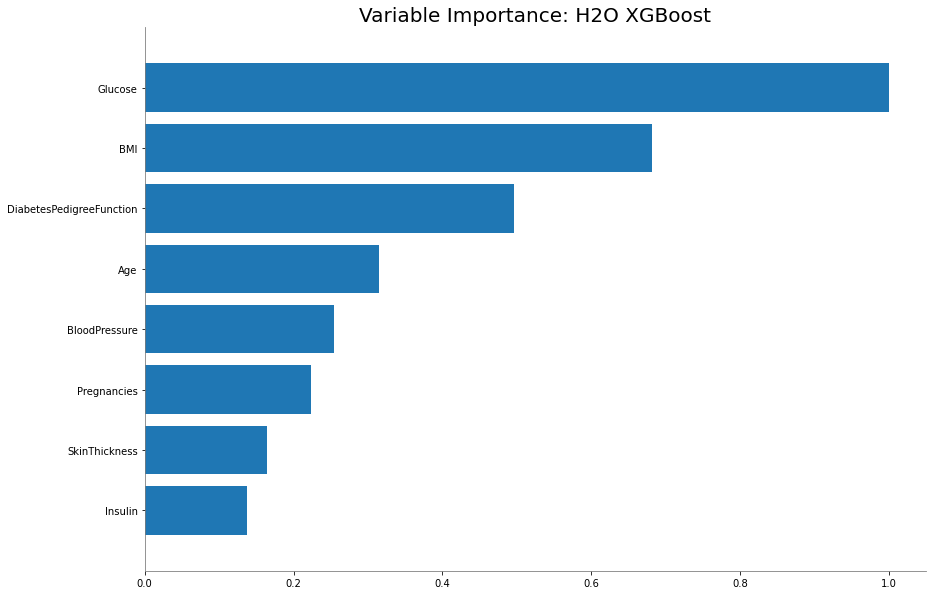

<Figure size 432x288 with 0 Axes>

In [ ]:
cv_xgb.varimp_plot()

Time to use AUTO ML. 
**AutoML : Automatic Machine Learning:** ==> H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. Stacked Ensembles will be automatically trained on collections of individual models to produce highly predictive ensemble models which, in most cases, will be the top performing models in the AutoML Leaderboard.

In [ ]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models = 10, max_runtime_secs=100, seed = 1)
aml.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

AutoML progress: |
12:08:22.371: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_1_20220415_120822


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,42.0,42.0,45661.0,10.0,17.0,13.452381,65.0,100.0,81.666664




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.16440960271068342
RMSE: 0.4054745401510228
LogLoss: 0.8344361335366673
Mean Per-Class Error: 0.23919087722125965
AUC: 0.8153785711407503
AUCPR: 0.700970825419835
Gini: 0.6307571422815006

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35: 


,,0,1,Error,Rate
0,0,210.0,89.0,0.2977,(89.0/299.0)
1,1,30.0,136.0,0.1807,(30.0/166.0)
2,Total,240.0,225.0,0.2559,(119.0/465.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.350000,0.695652,85.0
1,max f2,0.266667,0.786638,101.0
2,max f0point5,0.482270,0.681818,56.0
3,max accuracy,0.482270,0.772043,56.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000000,1.000000,150.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.482270,0.500879,56.0
8,max min_per_class_accuracy,0.411765,0.746988,72.0
9,max mean_per_class_accuracy,0.350000,0.760809,85.0



Gains/Lift Table: Avg response rate: 35.70 %, avg score: 36.54 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010753,0.938824,2.240964,2.240964,0.800000,0.966471,0.800000,0.966471,0.024096,0.024096,124.096386,124.096386,0.020752
1,2,0.021505,0.895059,2.801205,2.521084,1.000000,0.928333,0.900000,0.947402,0.030120,0.054217,180.120482,152.108434,0.050872
2,3,0.032258,0.875000,1.680723,2.240964,0.600000,0.877941,0.800000,0.924248,0.018072,0.072289,68.072289,124.096386,0.062256
3,4,0.043011,0.857143,2.240964,2.240964,0.800000,0.857143,0.800000,0.907472,0.024096,0.096386,124.096386,124.096386,0.083008
4,5,0.053763,0.842105,2.801205,2.353012,1.000000,0.846073,0.840000,0.895192,0.030120,0.126506,180.120482,135.301205,0.113128
5,6,0.101075,0.787970,2.291895,2.324404,0.818182,0.817126,0.829787,0.858651,0.108434,0.234940,129.189485,132.440400,0.208184
6,7,0.150538,0.722909,2.070456,2.240964,0.739130,0.755820,0.800000,0.824863,0.102410,0.337349,107.045574,124.096386,0.290527
7,8,0.202151,0.666667,1.750753,2.115804,0.625000,0.689911,0.755319,0.790407,0.090361,0.427711,75.075301,111.580364,0.350788
8,9,0.303226,0.529412,1.668803,1.966803,0.595745,0.585509,0.702128,0.722108,0.168675,0.596386,66.880287,96.680338,0.455917
9,10,0.402151,0.428571,1.157019,1.767605,0.413043,0.478052,0.631016,0.662073,0.114458,0.710843,15.701938,76.760518,0.480074




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.17229692194273172
RMSE: 0.41508664389827304
LogLoss: 0.501410044540819
Mean Per-Class Error: 0.2691530220335557
AUC: 0.8009904992925005
AUCPR: 0.6966438472127967
Gini: 0.6019809985850011

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2857142857142857: 


,,0,1,Error,Rate
0,0,60.0,37.0,0.3814,(37.0/97.0)
1,1,8.0,43.0,0.1569,(8.0/51.0)
2,Total,68.0,80.0,0.3041,(45.0/148.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.285714,0.656489,41.0
1,max f2,0.119048,0.798722,54.0
2,max f0point5,0.761905,0.650407,8.0
3,max accuracy,0.761905,0.750000,8.0
4,max precision,0.952381,1.000000,0.0
5,max recall,0.095238,1.000000,56.0
6,max specificity,0.952381,1.000000,0.0
7,max absolute_mcc,0.315096,0.440748,39.0
8,max min_per_class_accuracy,0.380952,0.711340,34.0
9,max mean_per_class_accuracy,0.315096,0.731858,39.0



Gains/Lift Table: Avg response rate: 34.46 %, avg score: 35.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.033784,0.928571,2.901961,2.901961,1.000000,0.933333,1.000000,0.933333,0.098039,0.098039,190.196078,190.196078,0.098039
1,2,0.033784,0.909048,0.000000,2.901961,0.000000,0.000000,1.000000,0.933333,0.000000,0.098039,-100.000000,190.196078,0.098039
2,3,0.054054,0.880952,2.901961,2.901961,1.000000,0.880952,1.000000,0.913690,0.058824,0.156863,190.196078,190.196078,0.156863
3,4,0.054054,0.872619,0.000000,2.901961,0.000000,0.000000,1.000000,0.913690,0.000000,0.156863,-100.000000,190.196078,0.156863
4,5,0.101351,0.764048,2.487395,2.708497,0.857143,0.804762,0.933333,0.862857,0.117647,0.274510,148.739496,170.849673,0.264201
5,6,0.155405,0.713374,1.088235,2.144928,0.375000,0.742063,0.739130,0.820842,0.058824,0.333333,8.823529,114.492754,0.271478
6,7,0.209459,0.642857,1.450980,1.965844,0.500000,0.670339,0.677419,0.782003,0.078431,0.411765,45.098039,96.584440,0.308672
7,8,0.310811,0.500000,1.354248,1.766411,0.466667,0.548311,0.608696,0.705799,0.137255,0.549020,35.424837,76.641091,0.363453
8,9,0.405405,0.404762,1.450980,1.692810,0.500000,0.433279,0.583333,0.642211,0.137255,0.686275,45.098039,69.281046,0.428543
9,10,0.500000,0.312310,1.243697,1.607843,0.428571,0.363752,0.554054,0.589529,0.117647,0.803922,24.369748,60.784314,0.463715




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.15154308101802944
RMSE: 0.38928534652363866
LogLoss: 0.6698533159343569
Mean Per-Class Error: 0.2301547326429464
AUC: 0.8406938791957126
AUCPR: 0.7538605020823073
Gini: 0.6813877583914252

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31999999999999995: 


,,0,1,Error,Rate
0,0,210.0,89.0,0.2977,(89.0/299.0)
1,1,27.0,139.0,0.1627,(27.0/166.0)
2,Total,237.0,228.0,0.2495,(116.0/465.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.320000,0.705584,81.0
1,max f2,0.180000,0.792181,110.0
2,max f0point5,0.656667,0.725490,33.0
3,max accuracy,0.520000,0.787097,53.0
4,max precision,0.971429,1.000000,0.0
5,max recall,0.000000,1.000000,136.0
6,max specificity,0.971429,1.000000,0.0
7,max absolute_mcc,0.440000,0.529085,67.0
8,max min_per_class_accuracy,0.380000,0.765886,75.0
9,max mean_per_class_accuracy,0.320000,0.769845,81.0



Gains/Lift Table: Avg response rate: 35.70 %, avg score: 35.62 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012903,0.920000,2.334337,2.334337,0.833333,0.941905,0.833333,0.941905,0.030120,0.030120,133.433735,133.433735,0.026776
1,2,0.021505,0.884114,2.801205,2.521084,1.000000,0.900000,0.900000,0.925143,0.024096,0.054217,180.120482,152.108434,0.050872
2,3,0.034409,0.880000,2.334337,2.451054,0.833333,0.880000,0.875000,0.908214,0.030120,0.084337,133.433735,145.105422,0.077648
3,4,0.047312,0.860000,2.801205,2.546550,1.000000,0.860417,0.909091,0.895179,0.036145,0.120482,180.120482,154.654984,0.113793
4,5,0.053763,0.840000,2.801205,2.577108,1.000000,0.843333,0.920000,0.888957,0.018072,0.138554,180.120482,157.710843,0.131865
5,6,0.105376,0.742857,2.217620,2.401033,0.791667,0.781994,0.857143,0.836567,0.114458,0.253012,121.762048,140.103270,0.229601
6,7,0.150538,0.695500,2.534423,2.441050,0.904762,0.717718,0.871429,0.800912,0.114458,0.367470,153.442341,144.104991,0.337370
7,8,0.202151,0.640000,1.984187,2.324404,0.708333,0.661498,0.829787,0.765317,0.102410,0.469880,98.418675,132.440400,0.416368
8,9,0.301075,0.512679,1.522394,2.060886,0.543478,0.575536,0.735714,0.702960,0.150602,0.620482,52.239392,106.088640,0.496736
9,10,0.412903,0.400000,1.185125,1.823701,0.423077,0.451052,0.651042,0.634735,0.132530,0.753012,18.512512,82.370105,0.528932




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.791398,0.040662,0.838710,0.774193,0.806452,0.731183,0.806452
1,auc,0.837549,0.019566,0.857143,0.812562,0.856142,0.824230,0.837669
2,err,0.208602,0.040662,0.161290,0.225806,0.193548,0.268817,0.193548
3,err_count,19.400000,3.781534,15.000000,21.000000,18.000000,25.000000,18.000000
4,f0point5,0.703834,0.023625,0.740741,0.686813,0.686275,0.691057,0.714286
5,f1,0.719463,0.027058,0.761905,0.704225,0.700000,0.731183,0.700000
6,f2,0.736735,0.042063,0.784314,0.722543,0.714286,0.776256,0.686275
7,lift_top_group,1.808438,1.660104,3.100000,2.735294,3.206897,0.000000,0.000000
8,logloss,0.673691,0.307085,0.769231,1.170734,0.435954,0.524093,0.468445
9,max_per_class_error,0.279296,0.053165,0.200000,0.264706,0.275862,0.333333,0.322581



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-04-15 12:08:30,2.717 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-04-15 12:08:30,2.762 sec,5.0,0.513966,6.706648,0.689726,0.537397,1.716867,0.342857,0.433081,1.387083,0.766929,0.635615,2.487395,0.324324
2,,2022-04-15 12:08:31,2.819 sec,10.0,0.460863,3.627067,0.746510,0.584566,1.820783,0.316703,0.418183,0.509922,0.792197,0.670478,2.901961,0.317568
3,,2022-04-15 12:08:31,2.898 sec,15.0,0.433738,2.115143,0.782027,0.629866,2.000861,0.263499,0.410124,0.498852,0.802911,0.706439,2.901961,0.290541
4,,2022-04-15 12:08:31,2.976 sec,20.0,0.420591,1.535870,0.799301,0.653096,2.037240,0.281720,0.416608,0.508282,0.795937,0.698244,2.901961,0.283784
5,,2022-04-15 12:08:31,3.053 sec,25.0,0.418299,1.331980,0.799553,0.660167,2.000861,0.258065,0.413644,0.496948,0.801597,0.701467,2.901961,0.304054
6,,2022-04-15 12:08:31,3.119 sec,30.0,0.410168,1.045066,0.810946,0.678849,2.000861,0.245161,0.416312,0.504992,0.795432,0.684025,2.901961,0.304054
7,,2022-04-15 12:08:31,3.205 sec,35.0,0.410603,0.978055,0.808468,0.680608,1.680723,0.249462,0.414707,0.501719,0.798565,0.691033,2.901961,0.263514
8,,2022-04-15 12:08:31,3.284 sec,40.0,0.407985,0.838591,0.811661,0.684110,2.240964,0.258065,0.414185,0.500091,0.800889,0.692525,2.901961,0.283784
9,,2022-04-15 12:08:31,3.344 sec,42.0,0.405475,0.834436,0.815379,0.700971,2.240964,0.255914,0.415087,0.501410,0.800990,0.696644,2.901961,0.304054



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Glucose,929.600952,1.000000,0.307034
1,BMI,478.234161,0.514451,0.157954
2,DiabetesPedigreeFunction,369.895142,0.397907,0.122171
3,Age,334.504486,0.359837,0.110482
4,Pregnancies,267.205322,0.287441,0.088254
5,BloodPressure,243.634857,0.262085,0.080469
6,Insulin,208.704575,0.224510,0.068932
7,SkinThickness,195.899902,0.210735,0.064703


In [ ]:
lb = aml.leaderboard
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DRF_1_AutoML_1_20220415_120822,0.840694,0.669853,0.753861,0.230155,0.389285,0.151543
StackedEnsemble_BestOfFamily_1_AutoML_1_20220415_120822,0.832736,0.479362,0.721094,0.234889,0.392271,0.153877
GBM_4_AutoML_1_20220415_120822,0.832121,0.473359,0.7492,0.235877,0.390696,0.152643
GLM_1_AutoML_1_20220415_120822,0.831638,0.488798,0.716653,0.238204,0.395915,0.156749
GBM_2_AutoML_1_20220415_120822,0.829985,0.480355,0.727995,0.238234,0.394038,0.155266
StackedEnsemble_AllModels_1_AutoML_1_20220415_120822,0.826027,0.486947,0.71757,0.249879,0.397346,0.157884
XRT_1_AutoML_1_20220415_120822,0.825976,0.555213,0.72196,0.232532,0.399288,0.159431
GBM_3_AutoML_1_20220415_120822,0.821655,0.490684,0.719058,0.251904,0.398949,0.15916
XGBoost_1_AutoML_1_20220415_120822,0.820687,0.492297,0.703893,0.248559,0.402223,0.161783
XGBoost_2_AutoML_1_20220415_120822,0.820264,0.501107,0.697644,0.239886,0.405695,0.164588


0.84 AUC is much better than all above ones tried so far. AUTOML winsss

In [ ]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

['DRF_1_AutoML_1_20220415_120822',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20220415_120822',
 'GBM_4_AutoML_1_20220415_120822',
 'GLM_1_AutoML_1_20220415_120822',
 'GBM_2_AutoML_1_20220415_120822',
 'StackedEnsemble_AllModels_1_AutoML_1_20220415_120822',
 'XRT_1_AutoML_1_20220415_120822',
 'GBM_3_AutoML_1_20220415_120822',
 'XGBoost_1_AutoML_1_20220415_120822',
 'XGBoost_2_AutoML_1_20220415_120822',
 'GBM_1_AutoML_1_20220415_120822',
 'XGBoost_3_AutoML_1_20220415_120822']

In [ ]:
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_BestOfFamily" in mid][0])
se

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_1_AutoML_1_20220415_120822

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09191042119840129
RMSE: 0.3031673155180177
LogLoss: 0.3167259659231442
Null degrees of freedom: 464
Residual degrees of freedom: 460
Null deviance: 606.0495845742382
Residual deviance: 294.5551483085241
AIC: 304.5551483085241
AUC: 0.9561187895394286
AUCPR: 0.9205092986158179
Gini: 0.9122375790788573

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4615944999074739: 


,,0,1,Error,Rate
0,0,273.0,26.0,0.087,(26.0/299.0)
1,1,24.0,142.0,0.1446,(24.0/166.0)
2,Total,297.0,168.0,0.1075,(50.0/465.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.461594,0.850299,154.0
1,max f2,0.287795,0.908059,200.0
2,max f0point5,0.546358,0.876812,122.0
3,max accuracy,0.465960,0.892473,151.0
4,max precision,0.945300,1.000000,0.0
5,max recall,0.169944,1.000000,263.0
6,max specificity,0.945300,1.000000,0.0
7,max absolute_mcc,0.461594,0.766445,154.0
8,max min_per_class_accuracy,0.391810,0.882943,167.0
9,max mean_per_class_accuracy,0.322757,0.892624,190.0



Gains/Lift Table: Avg response rate: 35.70 %, avg score: 36.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010753,0.907306,2.801205,2.801205,1.000000,0.920443,1.000000,0.920443,0.030120,0.030120,180.120482,180.120482,0.030120
1,2,0.021505,0.901066,2.801205,2.801205,1.000000,0.904394,1.000000,0.912418,0.030120,0.060241,180.120482,180.120482,0.060241
2,3,0.030108,0.893208,2.801205,2.801205,1.000000,0.897593,1.000000,0.908183,0.024096,0.084337,180.120482,180.120482,0.084337
3,4,0.040860,0.886547,2.801205,2.801205,1.000000,0.890800,1.000000,0.903608,0.030120,0.114458,180.120482,180.120482,0.114458
4,5,0.051613,0.880891,2.801205,2.801205,1.000000,0.882832,1.000000,0.899280,0.030120,0.144578,180.120482,180.120482,0.144578
5,6,0.101075,0.824163,2.679413,2.741605,0.956522,0.850398,0.978723,0.875359,0.132530,0.277108,167.941331,174.160472,0.273764
6,7,0.150538,0.768800,2.435830,2.641136,0.869565,0.792771,0.942857,0.848223,0.120482,0.397590,143.583028,164.113597,0.384212
7,8,0.200000,0.701130,2.679413,2.650602,0.956522,0.737543,0.946237,0.820850,0.132530,0.530120,167.941331,165.060241,0.513398
8,9,0.301075,0.518739,2.086004,2.461059,0.744681,0.613140,0.878571,0.751119,0.210843,0.740964,108.600359,146.105852,0.684108
9,10,0.400000,0.379439,1.583290,2.243976,0.565217,0.458636,0.801075,0.678785,0.156627,0.897590,58.328968,124.397590,0.773845




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.16782337576387477
RMSE: 0.409662514472431
LogLoss: 0.49507552554242434
Null degrees of freedom: 147
Residual degrees of freedom: 143
Null deviance: 190.73426440369713
Residual deviance: 146.54235556055764
AIC: 156.54235556055764
AUC: 0.8223165554881746
AUCPR: 0.7100501382185268
Gini: 0.6446331109763492

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3246590859780238: 


,,0,1,Error,Rate
0,0,69.0,28.0,0.2887,(28.0/97.0)
1,1,10.0,41.0,0.1961,(10.0/51.0)
2,Total,79.0,69.0,0.2568,(38.0/148.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.324659,0.683333,68.0
1,max f2,0.168227,0.824916,92.0
2,max f0point5,0.707739,0.664336,22.0
3,max accuracy,0.707739,0.756757,22.0
4,max precision,0.892325,1.000000,0.0
5,max recall,0.125870,1.000000,109.0
6,max specificity,0.892325,1.000000,0.0
7,max absolute_mcc,0.168227,0.498778,92.0
8,max min_per_class_accuracy,0.341788,0.731959,63.0
9,max mean_per_class_accuracy,0.324659,0.757631,68.0



Gains/Lift Table: Avg response rate: 34.46 %, avg score: 35.31 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013514,0.884369,2.901961,2.901961,1.000000,0.888583,1.000000,0.888583,0.039216,0.039216,190.196078,190.196078,0.039216
1,2,0.020270,0.878833,2.901961,2.901961,1.000000,0.883836,1.000000,0.887001,0.019608,0.058824,190.196078,190.196078,0.058824
2,3,0.033784,0.868084,2.901961,2.901961,1.000000,0.873521,1.000000,0.881609,0.039216,0.098039,190.196078,190.196078,0.098039
3,4,0.040541,0.865689,2.901961,2.901961,1.000000,0.867446,1.000000,0.879248,0.019608,0.117647,190.196078,190.196078,0.117647
4,5,0.054054,0.859742,2.901961,2.901961,1.000000,0.862602,1.000000,0.875087,0.039216,0.156863,190.196078,190.196078,0.156863
5,6,0.101351,0.800024,1.658263,2.321569,0.571429,0.833924,0.800000,0.855877,0.078431,0.235294,65.826331,132.156863,0.204366
6,7,0.155405,0.707736,2.539216,2.397272,0.875000,0.758256,0.826087,0.821922,0.137255,0.372549,153.921569,139.727195,0.331312
7,8,0.202703,0.636816,1.243697,2.128105,0.428571,0.670211,0.733333,0.786523,0.058824,0.431373,24.369748,112.810458,0.348898
8,9,0.304054,0.490732,1.160784,1.805664,0.400000,0.565315,0.622222,0.712787,0.117647,0.549020,16.078431,80.566449,0.373762
9,10,0.398649,0.360279,1.243697,1.672316,0.428571,0.414494,0.576271,0.642006,0.117647,0.666667,24.369748,67.231638,0.408935




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1538767056232615
RMSE: 0.39227121436993245
LogLoss: 0.47936235149450007
Null degrees of freedom: 464
Residual degrees of freedom: 461
Null deviance: 607.3498876444437
Residual deviance: 445.806986889885
AIC: 453.806986889885
AUC: 0.8327356247733408
AUCPR: 0.7210943175654569
Gini: 0.6654712495466817

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44261047192056246: 


,,0,1,Error,Rate
0,0,254.0,45.0,0.1505,(45.0/299.0)
1,1,53.0,113.0,0.3193,(53.0/166.0)
2,Total,307.0,158.0,0.2108,(98.0/465.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.442610,0.697531,146.0
1,max f2,0.245423,0.788043,235.0
2,max f0point5,0.716016,0.727848,72.0
3,max accuracy,0.471731,0.789247,138.0
4,max precision,0.758247,0.906250,60.0
5,max recall,0.006082,1.000000,395.0
6,max specificity,0.934738,0.996656,0.0
7,max absolute_mcc,0.442610,0.536351,146.0
8,max min_per_class_accuracy,0.340414,0.734940,186.0
9,max mean_per_class_accuracy,0.442610,0.765111,146.0



Gains/Lift Table: Avg response rate: 35.70 %, avg score: 35.65 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010753,0.908081,1.680723,1.680723,0.600000,0.920250,0.600000,0.920250,0.018072,0.018072,68.072289,68.072289,0.011383
1,2,0.021505,0.893575,2.240964,1.960843,0.800000,0.902108,0.700000,0.911179,0.024096,0.042169,124.096386,96.084337,0.032135
2,3,0.030108,0.870072,2.801205,2.200947,1.000000,0.877037,0.785714,0.901424,0.024096,0.066265,180.120482,120.094664,0.056232
3,4,0.040860,0.865210,1.680723,2.064046,0.600000,0.867430,0.736842,0.892478,0.018072,0.084337,68.072289,106.404566,0.067615
4,5,0.051613,0.855312,2.801205,2.217620,1.000000,0.860677,0.791667,0.885853,0.030120,0.114458,180.120482,121.762048,0.097735
5,6,0.101075,0.797635,2.679413,2.443604,0.956522,0.828061,0.872340,0.857572,0.132530,0.246988,167.941331,144.360420,0.226921
6,7,0.150538,0.732068,2.557622,2.481067,0.913043,0.763418,0.885714,0.826636,0.126506,0.373494,155.762179,148.106713,0.346738
7,8,0.200000,0.648676,1.826873,2.319277,0.652174,0.697999,0.827957,0.794822,0.090361,0.463855,82.687271,131.927711,0.410344
8,9,0.301075,0.493495,1.490003,2.040878,0.531915,0.565666,0.728571,0.717891,0.150602,0.614458,49.000256,104.087780,0.487368
9,10,0.400000,0.370436,1.035228,1.792169,0.369565,0.427520,0.639785,0.646079,0.102410,0.716867,3.522787,79.216867,0.492787




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.784194,0.057168,0.789474,0.708738,0.855556,0.750000,0.817204
1,auc,0.838330,0.030815,0.846230,0.804059,0.884979,0.818713,0.837669
2,err,0.215806,0.057168,0.210526,0.291262,0.144444,0.250000,0.182796
3,err_count,20.200000,6.300794,20.000000,30.000000,13.000000,21.000000,17.000000
4,f0point5,0.687436,0.068530,0.679348,0.639098,0.789474,0.614973,0.714286
5,f1,0.732583,0.055042,0.714286,0.693878,0.821918,0.686567,0.746269
6,f2,0.785472,0.041785,0.753012,0.758929,0.857143,0.777027,0.781250
7,lift_top_group,2.235860,1.276541,2.968750,2.452381,2.647059,3.111111,0.000000
8,logloss,0.475089,0.038402,0.455290,0.531590,0.427603,0.479625,0.481335
9,max_per_class_error,0.246383,0.081612,0.218750,0.360656,0.160714,0.298246,0.193548



See the whole table with table.as_data_frame()


In [ ]:
#metalearner = h2o.get_model(aml.leader.metalearner()['name'])  ==> This did not work so splitting it
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])
#metalearner.std_coef_plot()

/usr/local/lib/python3.7/dist-packages/h2o/estimators/stackedensemble.py:929: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


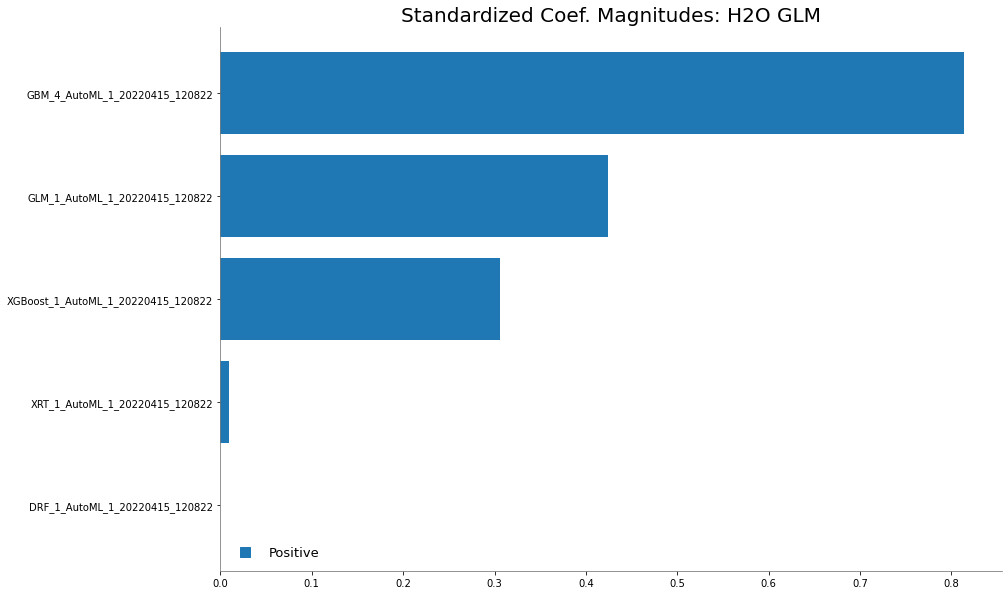

In [ ]:
metalearner.std_coef_plot()